In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import linregress, ttest_ind
from tabulate import tabulate

In [2]:

#Table showing the results of three tests measuring correlation between ANS and the other cognitive tests (using the Spearman rank-order method)
#e.g. two columns: measured correlation value and significance (p-value), three rows for each of the tests (ANS vs maths, ANS vs correlation, ANS vs spatial reasoning).


In [3]:
#first, we need to identify if there are any outliers before we graph histograms showing distribution
#Here, we use Statistical Methods,  IQR
ans= pd.read_csv("ANS test.csv")
math= pd.read_csv("maths data.csv")
memory= pd.read_csv("memory_test.csv")

def outlier (column):
    q1, q3 = np.percentile(column, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    column = column[(column >= lower_bound) & (column <= upper_bound)]
    return column
            
math["score"] = outlier(math["correct_answers"])
math = math.dropna(subset=["score"])
ans["score"] = outlier(ans["Correct response"])
ans = ans.dropna(subset=["score"])
memory["score"] = outlier(memory["n_correct_answers"])
memory = memory.dropna(subset=["score"])

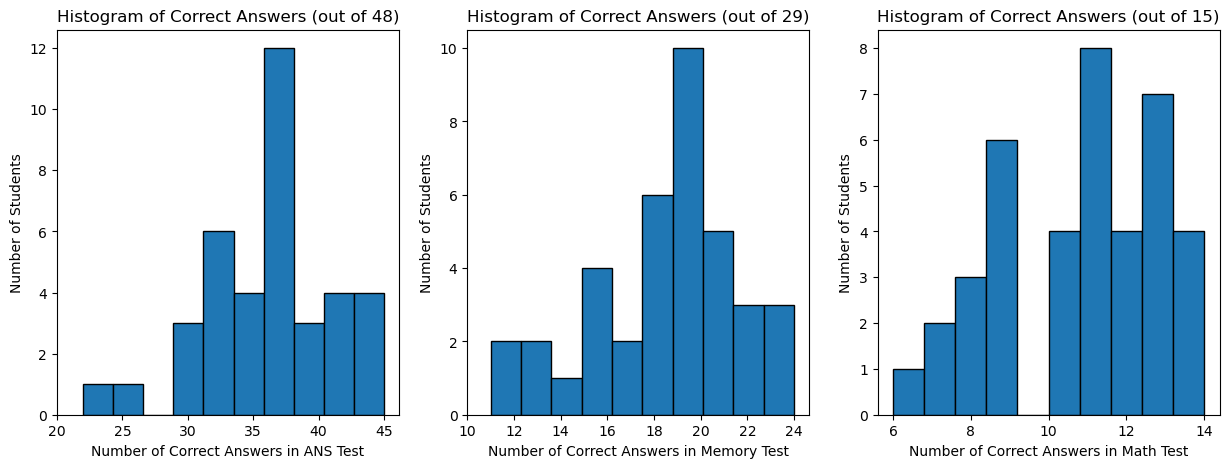

In [4]:
#Since there are no outliers, we proceed to graph histograms showing distribution of correct answers
#I want to create a plot with 3 histograms in a row to make it clearer
fig, ax = plt.subplots(1,3, figsize=(15, 5))
ANS_srt = ans[["User id", "score"]].set_index("User id")
ax[0].hist(ANS_srt, bins = 10, edgecolor='black')
ax[0].set_xlabel("Number of Correct Answers in ANS Test")
ax[0].set_xticks(np.arange(20, 46, step=5))
ax[0].set_ylabel("Number of Students")
ax[0].set_title("Histogram of Correct Answers (out of 48)")
memory_srt = memory[["ID", "score"]].set_index("ID")
ax[1].hist(memory_srt, bins = 10, edgecolor='black')
ax[1].set_xlabel("Number of Correct Answers in Memory Test")
ax[1].set_xticks(np.arange(10, 25, step=2))
ax[1].set_ylabel("Number of Students")
ax[1].set_title("Histogram of Correct Answers (out of 29)")
math_srt = math[["user_id", "score"]].set_index("user_id")
ax[2].hist(math_srt, bins = 10, edgecolor='black')
ax[2].set_xlabel("Number of Correct Answers in Math Test")
ax[2].set_xticks(np.arange(6, 15, step=2))
ax[2].set_ylabel("Number of Students")
ax[2].set_title("Histogram of Correct Answers (out of 15)")

plt.show()

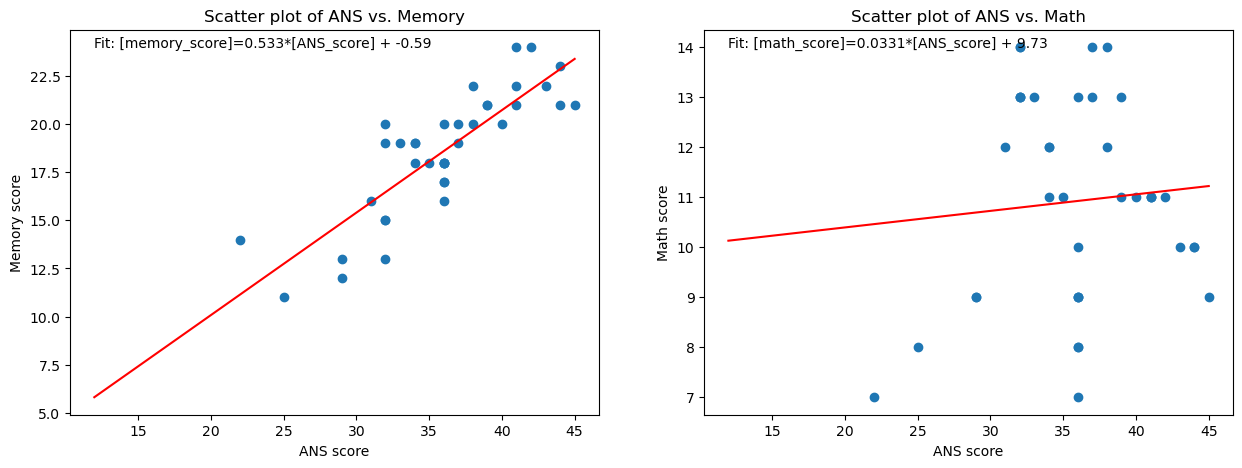

In [5]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))
ANS_merged_memory = ANS_srt.merge(memory_srt, left_index=True, right_index=True)
ANS_merged_math = ANS_srt.merge(math_srt, left_index=True, right_index=True)
ax[0].scatter(ANS_merged_memory["score_x"], ANS_merged_memory["score_y"])
ax[0].set_xlabel("ANS score")
ax[0].set_ylabel("Memory score")
ax[0].set_title("Scatter plot of ANS vs. Memory")
ax[1].scatter(ANS_merged_math["score_x"], ANS_merged_math["score_y"])
ax[1].set_xlabel("ANS score")
ax[1].set_ylabel("Math score")
ax[1].set_title("Scatter plot of ANS vs. Math")
(slope1, intercept1, rvalue1, pvalue1, stderr1) = linregress(ANS_merged_memory["score_x"], ANS_merged_memory["score_y"])
(slope2, intercept2, rvalue2, pvalue2, stderr2) = linregress(ANS_merged_math["score_x"], ANS_merged_math["score_y"])


# to draw line we take x values at each end of the plot
x0 = 12
x1 = 45

# then use eqn to find corresponding y-values
y0 = x0*slope1+intercept1
y1 = x1*slope1+intercept1

# we can now plot a line from (x0,y0) to (x1,y1)
ax[0].text(12,24, f"Fit: [memory_score]={slope1:.3g}*[ANS_score] + {intercept1:.3g}")
lines = ax[0].plot([x0,x1],[y0,y1],'r-')

y0 = x0*slope2+intercept2
y1 = x1*slope2+intercept2

# we can now plot a line from (x0,y0) to (x1,y1)
ax[1].text(12,14, f"Fit: [math_score]={slope2:.3g}*[ANS_score] + {intercept2:.3g}")
lines = ax[1].plot([x0,x1],[y0,y1],'r-')


In [6]:
#data analysis
rsquared1 = rvalue1*rvalue1
rsquared2 = rvalue2*rvalue2
dic1 = {"":["ANS vs. Memory", "ANS vs. Math"],
          "R-squared value":[f"{rsquared1:.3g}", f"{rsquared2:.3g}"],
          "P-value":[f"{pvalue1:.3g}", f"{pvalue2:.3g}"]}
df = pd.DataFrame(dic1).set_index("")
df

,R-squared value,P-value
,,
ANS vs. Memory,0.707,3.96e-11
ANS vs. Math,0.00676,0.624


In [62]:
def t_test(new_df, ID):
    mean_score_individual = []
    row_num = 0

    for correct_answer in new_df["Correct"]:
        scores = []
        for col in new_df.columns[:-1]:  # Exclude the "Correct" column
            # Compare the answer for each row (question) with the correct answer
            if new_df[col].iloc[row_num] == correct_answer:
                scores.append(1)
            else:
                scores.append(0)
        mean_score_individual.append(sum(scores)/len(ID))

    new_df["mean_score_individual"] = mean_score_individual

    even_num_result = new_df1["mean_score_individual"].iloc[1::2]
    odd_num_result = new_df1["mean_score_individual"].iloc[0::2]

    p_value= ttest_ind(even_num_result, odd_num_result).pvalue
    
    return p_value

In [63]:
def dotplot(new_df):
    fig, ax = plt.subplots() 

    index_label = []
    for i in new_df.index:
        if (i) % 2 != 0:
            index_label.append("odd")
        else:
            index_label.append("even")

    df_4_plot = pd.DataFrame({ 'index_label': index_label, 'ind_ave': new_df["mean_score_individual"] } )

    ax.plot(df_4_plot['index_label'],df_4_plot["ind_ave"],'o')
    ax.set_xlim(-1,2)

    odd_df = df_4_plot.query( "index_label=='odd'" )
    even_df = df_4_plot.query( "index_label=='even'" )

    odd_mean = odd_df['ind_ave'].mean()
    odd_std_err = stats.sem(odd_df['ind_ave'])

    even_mean = even_df['ind_ave'].mean()
    even_std_err = stats.sem(even_df['ind_ave'])

    ax.errorbar('odd',odd_mean,  yerr=odd_std_err,  marker='_',  color='black')
    ax.errorbar('even',even_mean,  yerr=even_std_err,  marker='_',  color='black')
    ax.set_xlabel(f"P-value for t-test is {p_value:.3g}",color='blue', fontsize='large', labelpad=20)
    ax.set_ylabel("Correct rate of individual questions")
    ax.set_title("Memory Test Average Scores of Odd-numbered vs Even-numbered Questions")

    plt.show()
    return

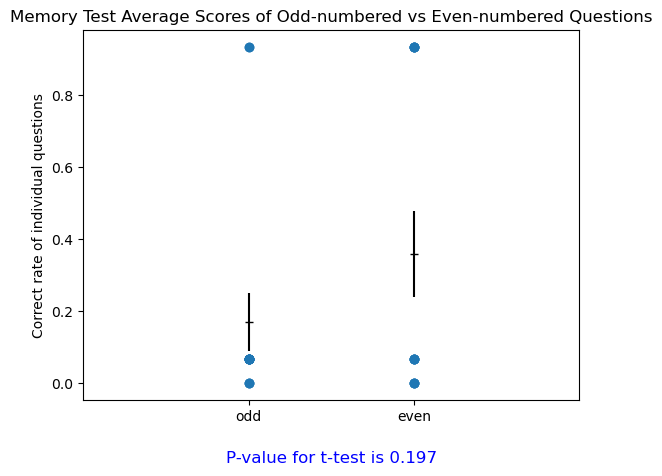

1     0.933333
2     0.066667
3     0.066667
4     0.933333
5     0.000000
6     0.066667
7     0.066667
8     0.933333
9     0.066667
10    0.933333
11    0.000000
12    0.066667
13    0.066667
14    0.933333
15    0.066667
16    0.000000
17    0.933333
18    0.066667
19    0.066667
20    0.000000
21    0.066667
22    0.000000
23    0.066667
24    0.933333
25    0.000000
26    0.066667
27    0.066667
28    0.000000
29    0.066667
Name: mean_score_individual, dtype: float64


In [64]:
df1 = pd.read_csv("memory_individual.csv")
#extract the user_answer column and split these strings of answers into a series of lists.
user_answers = df1['user_answer'].str.split(', ')
#create a new dataframe by setting the index label as ID and column label as question number
#fill the user_answer to the new dataframe as rows. The user_answer is series.
#When call .tolist() on this Series, it converts the Series itself into a list. Since each element of the Series is already a list, the result is a list of lists.
#flip the index and columns for easier manipulations later
new_df1 = pd.DataFrame(user_answers.tolist(), index=df1['ID'], columns=range(1, 30)).transpose()
new_df1["Correct"] = ["a", "b", "b", "a", "c", "b", "b", "a","b","a","c","b","b", "a", "b", "c", "a","b","b","c", "b", "c", "b", "a", "c","b", "b","c", "b"]

p_value = t_test(new_df1, df1['ID'])

dotplot_memory = dotplot(new_df1)
print(new_df1["mean_score_individual"])

In [ ]:
# df2 = pd.read_csv("ANS_individual.csv")
# user_answers = df2['user response'].str.split(', ')
# new_df2 = pd.DataFrame(user_answers.tolist(), index=df2['User id'], columns=range(1, 49)).transpose()
# new_df2["Correct"] = []

# p_value = t_test(new_df2, df2['User id'])

# dotplot_ANS = dotplot(new_df2)